In [15]:
import os
import sys
sys.path.append('..')
sys.path.append('../src')
import torch
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import decode_image

from qdrant_client.models import Distance

from src.image_encoder import PreTrainedImageEncoder
from src.image_process import load_image_and_metadata, show_image
from src.evaluation import mean_average_precision, extract_retrieved_point_data
from src.qdrant_vector_db import QdrantVectorDB

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Create Ground Truth

The ground truth is created according to image pair_id. Images with the same pair_id indicates same clothes (may include different colors and logos). Therefore, it's natural to regard retrieved images with the same pair_id as relevant images, labeling as positive retrieval.

**Example**:
```python
- query_image_metadata = {'pair_id': 1}
- retrieved_image_metadata = [{'pair_id': 1}, {'pair_id': 2}]
```
Then the first retrieved image is relevant (positive) while the second is not (negative).

# 2. Define metrics

There are several commonly used metrics in the field of Information Retrieval. Such as:

1. Mean Reciprocal rank (MRR)
2. Mean average precision (mAP)
3. Normalized discounted cumulative gain (nDCG)

mAP is selected since the relevance score is binary.

In [130]:
# A toy case of mPA
t = torch.tensor(
    [[0,1,0,1],
     [0,0,0,1],
     [1,1,1,0]]
)
mean_average_precision(t)

tensor(0.5833)

# 3. Create Evaluation Pipeline

## 3.1 Load Image Information and Encoder

In [2]:
# import df image info
df_image_info = pd.read_csv('../data/validation/file_pair_id.csv')
# only use user image as queries
df_image_info = df_image_info[df_image_info['img_source']=='user'].sample(5000, random_state=100)
print(f"Totally {df_image_info.shape[0]} of images.")

# reset index
df_image_info = df_image_info.reset_index()
print(f"df index: {df_image_info.index}")
df_image_info.head(3)

Totally 5000 of images.
df index: RangeIndex(start=0, stop=5000, step=1)


,index,filename,pair_id,img_source
0,7505,007506.json,1638,user
1,2451,002452.json,517,user
2,6376,006377.json,1377,user


In [3]:
# Load image encoder:

# cache weights to a project folder
os.environ['TORCH_HOME'] = '../cache'
# select device
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

# Init model with pre-trained weights
pre_trained_weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=pre_trained_weights)

# Create image encoder from pre-trained model
image_encoder = PreTrainedImageEncoder(model, device=device)

# Set encoder to eval mode
image_encoder.eval()

# Init transforms
image_process = pre_trained_weights.transforms()

# Move to gpu if possible
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
image_encoder.to(device)
image_encoder.eval()

print("Image Encoder Loaded.")

Image Encoder Loaded.


## 3.2 Load and Encode

In [5]:
img_dir = '../data/validation/image'
metadata_dir = '../data/validation/annos'
saving_dir = "../data/validation/"
batch_size = 64

In [38]:
img_embeddings = []
metadata_list = []
for i in range(0, df_image_info.shape[0], batch_size):
    df_tmp = df_image_info[i: i+batch_size]

    # Load data
    img_tensors = []
    for idx, row in df_tmp.iterrows():
        image_name = row['filename'].split('.')[0]
    
        img, md = load_image_and_metadata(image_name, img_dir, metadata_dir)
    
        # transform img
        img = image_process(img)
    
        img_tensors.append(img)
        metadata_list.append(md)

    img_tensors = torch.stack(img_tensors).to(device)

    # Encode
    with torch.no_grad():
        model_output = image_encoder(img_tensors)
        model_output = model_output.cpu()
        img_embeddings.append(model_output)


In [40]:
# Concatenate image embeddings
img_embeddings = torch.concat(img_embeddings)
img_embeddings = img_embeddings.numpy()
img_embeddings.shape

(5000, 2048)

In [77]:
# Save embeddings and metadata
with open(
    os.path.join(saving_dir, 'eval_embed_rs100.pk'), 'wb'
) as f:
    pickle.dump(img_embeddings, f)

with open(
    os.path.join(saving_dir, 'eval_meta_rs100.pk'), 'wb'
) as f:
    pickle.dump(metadata_list, f)

## 3.3 Load Vector Db

In [41]:
# Load Vector database
# Config
db_name = 'image_db'
db_path = '../vector_database'
db_client = QdrantVectorDB.init_client(db_path)
# loaded vector db
qdrant_db = QdrantVectorDB.load_db(
    database_name=db_name, 
    database_path=db_path, 
    client=db_client,
)

/mnt/d/visual-search/experiments/../src/qdrant_vector_db.py:25: UserWarning: Local mode is not recommended for collections with more than 20,000 points. Collection <image_db> contains 21309 points. Consider using Qdrant in Docker or Qdrant Cloud for better performance with large datasets.
  client = QdrantClient(path=database_path)
INFO:root:Loaded Qdrant collection 'image_db' with dimension 2048 and distance 'Cosine'.


## 3.4 Run Visual Search

In [83]:
# Return 10 images for each query
k = 10


retrieving_results = []
for i in range(img_embeddings.shape[0]):
    
    ret_imgs = qdrant_db.query_image(query_vector=img_embeddings[i], k=k)

    extra_data = {'query_img_id': i, 'query_img_pair_id': metadata_list[i]['pair_id']}
    # Extract data for evaluation
    retrieving_results.extend(
        [extract_retrieved_point_data(point, extra_data) for point in ret_imgs]
    )

In [84]:
df_res = pd.DataFrame(retrieving_results)

In [87]:
with open(os.path.join(saving_dir, 'search_res.pk'), 'wb') as f:
    pickle.dump(df_res, f)

In [133]:
df_eval = df_res['query_img_id'].copy().to_frame()
df_eval['relevant'] = (df_res['query_img_pair_id']==df_res['pair_id']).astype('int64')

relevant_scores = df_eval.groupby('query_img_id')['relevant'].apply(lambda x: x.values).values
relevant_scores = np.stack(relevant_scores)
relevant_scores = torch.from_numpy(relevant_scores)
relevant_scores.size()

torch.Size([5000, 10])

In [134]:
mean_average_precision(relevant_scores)

tensor(0.0736)

# 4. Evaluation Analysis

Choose some examples to deep-dive into the search process. Although the retrieved images are not exact from the shops, they show high similarity to query images.

The model can be further fine tuned to achieve higher retrieval performance.

In [9]:
with open(os.path.join(saving_dir, 'search_res.pk'), 'rb') as f:
    df_res = pickle.load(f)

with open(
    os.path.join(saving_dir, 'eval_meta_rs100.pk'), 'rb'
) as f:
    metadata_list = pickle.load(f)

df_res.shape, len(metadata_list)

((50000, 6), 5000)

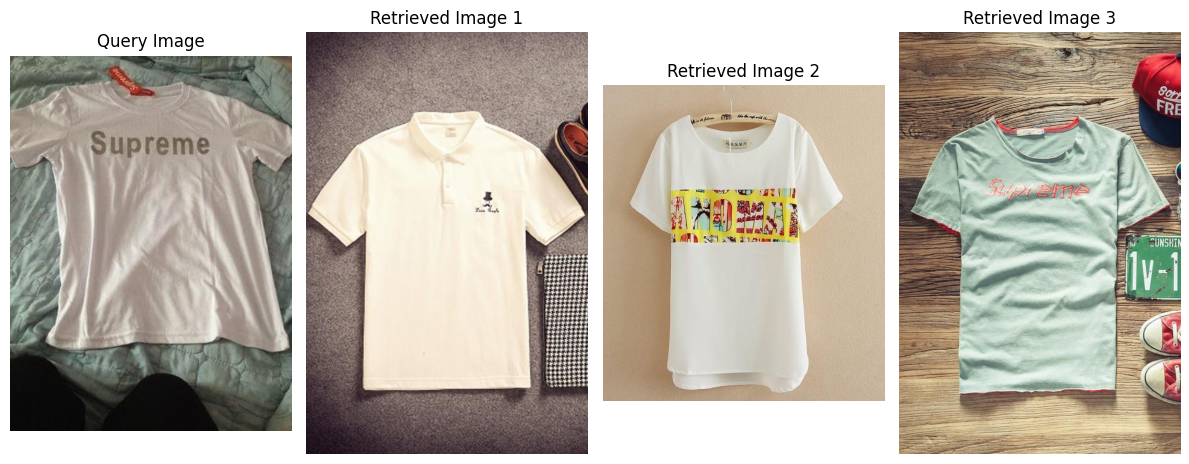

In [65]:
# get query img name from metadata
query_img_id = 25
query_img_name = metadata_list[query_img_id]['image_name']
all_img_names = [query_img_name]
retrieved_img = df_res.loc[(df_res['query_img_id']==query_img_id), 'image_name'].to_list()[:3]
all_img_names.extend(retrieved_img)

# load image tensors
img_tensor_list = []
for i in all_img_names:
    img_tensor, _ = load_image_and_metadata(i, image_dir=img_dir, metadata_dir=metadata_dir)
    img_tensor_list.append(img_tensor)

# Show images
fig, axes = plt.subplots(1, 4, figsize=(12, 9))

for i, ax in enumerate(axes.flatten()):
    if i >= len(img_tensor_list):
        break
    show_image(img_tensor_list[i], ax=ax)
    if i == 0:
        ax.set_title('Query Image')
    else:
        ax.set_title(f'Retrieved Image {i}')

plt.tight_layout()
plt.show()